## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [2]:
! git clone https://github.com/miacachion/pca_assignment.git

Cloning into 'pca_assignment'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 7 (from 1)
Receiving objects: 100% (12/12), 1.56 MiB | 6.04 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
import pickle
with open('pca_assignment/data/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

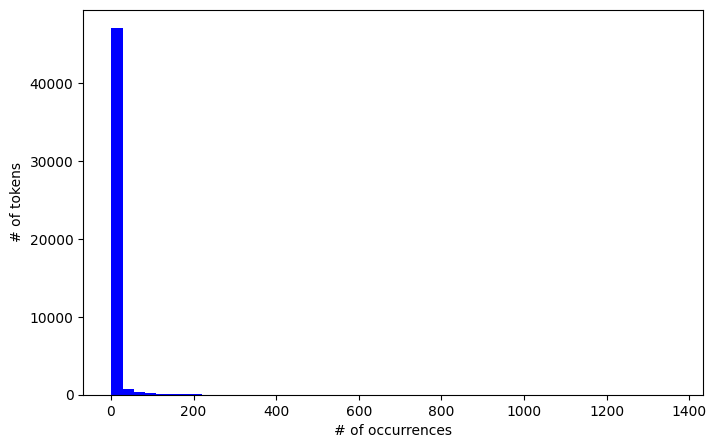

In [4]:
import matplotlib.pyplot as plt

counts = [count for word, count in token_freq]

plt.figure(figsize=(8, 5))
plt.hist(counts, bins=50, color='blue')
plt.xlabel("# of occurrences")
plt.ylabel("# of tokens")
plt.show()

The histogram is extremely crowded on the left side and very empty on the right side. There is very long right tail. This shows that most tokens/words occur only a few times, while a small number of tokens/words occur very frequently. This is a common distribution with language data because certain words can be more common, but most words appear rarely.

### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [5]:
import pandas as pd

emails = pd.read_parquet('pca_assignment/data/Phishing_clean.parquet')
emails.head()

,Email Type,new,date,get,please,enron,like,2002,would,one,...,ï¿½ï¿½,safety,yap,ypil,maintain,procedures,tip,elizabeth,leadership,italian
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#1

from sklearn.model_selection import train_test_split

X = emails.drop(columns=['Email Type'])
y = emails['Email Type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
#2

from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)

r2_train = linreg.score(X_train, y_train)
r2_test = linreg.score(X_test, y_test)

print("R squared training set:", round(r2_train, 3))
print("R squared test set:", round(r2_test, 3))

R squared training set: 0.767
R squared test set: 0.666


See cell output above for R squared values for both training and test sets.

In [8]:
#3

coef_df = pd.DataFrame({
    'token': X.columns,
    'coefficient': linreg.coef_
})

coef_df['abs_coef'] = coef_df['coefficient'].abs()
top_words = coef_df.sort_values(by='abs_coef', ascending=False).head(15)

top_words

,token,coefficient,abs_coef
835,intervention,-1.259257,1.259257
740,localized,0.824350,0.824350
2362,thermal,0.747006,0.747006
851,crawler,0.696167,0.696167
1504,background-image:,-0.622909,0.622909
1406,"helvetica,",0.598560,0.598560
906,aging,0.594956,0.594956
1839,form.,0.576886,0.576886
2242,gray;,-0.574480,0.574480
1552,a:active,0.574480,0.574480


The words with the largest absolute coefficients have the strongest influence on the model’s predictions of whether an e-mail is a scam or not. In this dataset, the top three tokens with the largest absolute coefficients are “intervention,” “localized,” and “thermal.”
These words contribute most strongly to the model’s decision because their presence, or absence, in an e-mail shifts the predicted value of Email Type more than other words. A large positive coefficient indicates that the word is associated with scam e-mails, while a large negative coefficient suggests it is more common in legitimate messages.

See the table above for the exact coefficient values.

### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

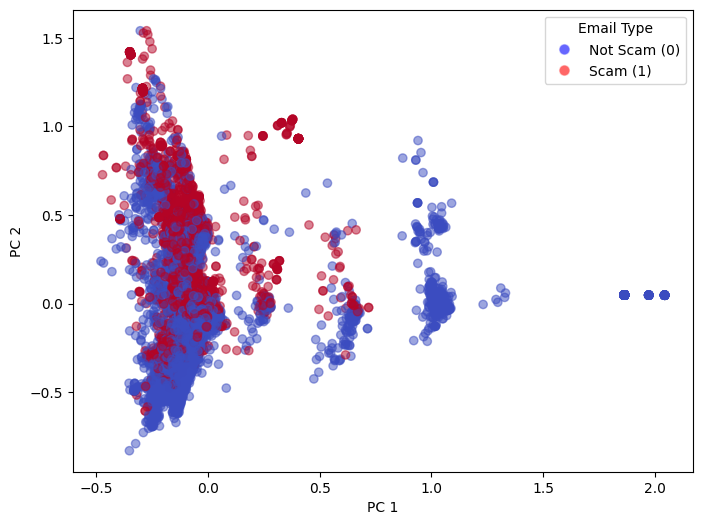

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Email Type': y
})

plt.figure(figsize=(8,6))
plt.scatter(
    pca_df['PC1'],
    pca_df['PC2'],
    c=pca_df['Email Type'],
    cmap='coolwarm',
    alpha=0.5,
)
plt.xlabel("PC 1")
plt.ylabel("PC 2")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Not Scam (0)',
           markerfacecolor='blue', markersize=8, alpha=0.6),
    Line2D([0], [0], marker='o', color='w', label='Scam (1)',
           markerfacecolor='red', markersize=8, alpha=0.6)
]

plt.legend(handles=legend_elements, title="Email Type")
plt.show()

There isn’t a perfect separation between scam and legitimate emails, but scam emails tend to cluster in certain areas. This indicates that the most important patterns in word usage often differ between phishing and non-phishing messages.

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [18]:
pca = PCA(n_components=2610)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

linreg.fit(X_train_pca, y_train)

r2_train_pca = linreg.score(X_train_pca, y_train)
r2_test_pca = linreg.score(X_test_pca, y_test)

print("R squared training set PCA:", round(r2_train_pca, 3))
print("R squared test set PCA:", round(r2_test_pca, 3))

R squared training set PCA: 0.766
R squared test set PCA: 0.668


The R squared values for regression on the top 2,610 principal components are very similar to those from the first linear regression. This means that reducing the number of features slightly simplified the model while keeping its predictive accuracy and even performing a little better on new data.

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using principal components rather than the original data reduces the number of features while still keeping most of the important information. This makes the regression simpler and less likely to overfit, without losing much predictive power. Using principle components also speeds up computation and helps the model focus on the most important differences between emails.

Academic Integrity: AI used for troubleshooting purposes.